In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive/11785/Data

In [ ]:
!ls

drive  sample_data


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf
import math

import os
import os.path as osp

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import numpy as np
import shutil
import cv2

In [ ]:
class VolumeSamples(torch.utils.data.Dataset):
  def __init__(self, data_path, partition= "train", context= 1, resize = 256):
    self.raw_paths = []
    self.mask_paths = []
    self.final_ids = []
    self.context = context
    self.resize = resize
    self.transforms = ttf.Compose([ttf.Resize((self.resize, self.resize)), ttf.ToTensor()])

    self.base_dirs = os.listdir(data_path)
    for sub_dir in self.base_dirs:
      raw_dir = data_path + "/" + sub_dir + "/Image/"
      mask_dir = data_path + "/" + sub_dir + "/Mask/"
      ids = []
      for files in os.listdir(mask_dir):
        file_number = files[5:len(files)-4]
        if not file_number.isnumeric():
          continue
        file_id = int(file_number)
        overlaid_file = mask_dir + "maskOverlayedImg_" + str(file_id) + ".jpg"
        if not os.path.exists(overlaid_file):
          continue
        ids.append(file_id)
      for id in ids:
        temp = True
        for con in range(context):
          change = con + 1
          if not((id - change) in ids and (id + change) in ids):
            temp = False
        if temp:
          self.final_ids.append(id)
          raw_path = raw_dir + "img" + str(id).zfill(4) + ".jpg"
          mask_path = mask_dir + "mask_" + str(id) + ".jpg"
          self.raw_paths.append(raw_path)
          self.mask_paths.append(mask_path)

    assert(len(self.raw_paths) == len(self.mask_paths))

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, ind):

    mask_path = self.mask_paths[ind]
    raw_path = self.raw_paths[ind]
    center_mask = self.transforms(Image.open(self.mask_paths[ind]).convert('RGB'))
    center_raw = self.transforms(Image.open(self.raw_paths[ind]).convert('RGB'))

    full_mask = []
    full_raw = []

    full_mask.append(center_mask)
    full_raw.append(center_raw)

    file_id = self.final_ids[ind]
    for con in range(self.context):
      before_id = file_id - con - 1

      before_raw_path = raw_path[0:raw_path.find("img")+3] + str(before_id).zfill(4) + ".jpg"
      before_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(before_id) + ".jpg"

      full_raw.insert(0, self.transforms(Image.open(before_raw_path).convert('RGB')))
      full_mask.insert(0, self.transforms(Image.open(before_mask_path).convert('RGB')))

      after_id = file_id + con + 1

      after_raw_path = raw_path[0:raw_path.find("img")+3] + str(after_id).zfill(4) + ".jpg"
      after_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(after_id) + ".jpg"

      full_raw.append(self.transforms(Image.open(before_raw_path).convert('RGB')))
      full_mask.append(self.transforms(Image.open(before_mask_path).convert('RGB')))

    return center_mask, center_raw, full_mask, full_raw

In [ ]:
g_root = "/content/drive/MyDrive/11785/Data"
root = "/content/Data"

#shutil.copytree(g_root, root)

In [ ]:
batch_size = 8
train_data = VolumeSamples(root, 'train', context = 3)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))

Batch size:  8
Train dataset samples = 2340, batches = 293


In [ ]:
from sklearn.model_selection import train_test_split
validation_split=0.1
seed=42
train,test = train_test_split(train_data, train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)

print(test[0])

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256]) 7 7


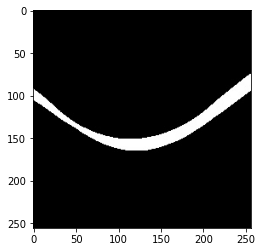

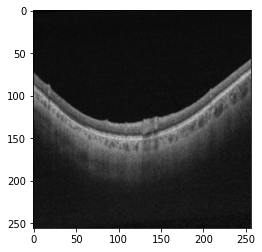

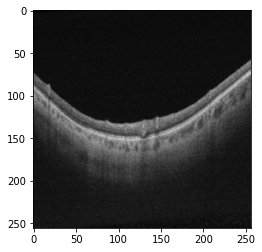

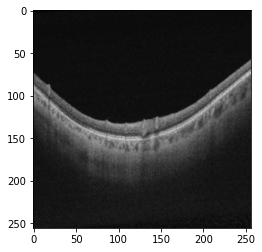

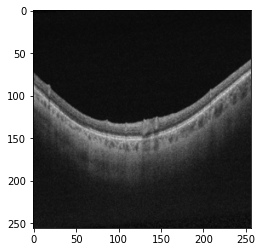

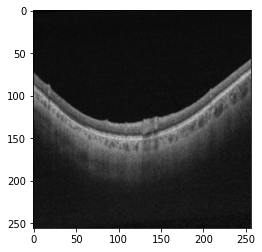

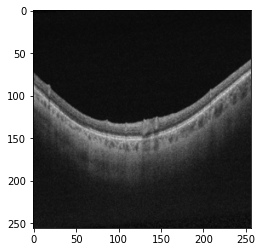

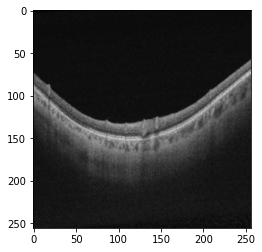

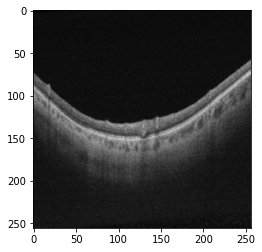

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
for data in train_loader:
    center_mask, center_raw, full_mask, full_raw = data
    print(center_mask.shape, center_raw.shape, len(full_mask), len(full_raw))
    plt.imshow(center_mask[0,:,:,:].permute(1,2,0))
    fig = plt.figure()
    plt.imshow(center_raw[0,:,:,:].permute(1,2,0))
    for i in range(len(full_raw)):
      fig = plt.figure()
      plt.imshow(full_raw[i][0,:,:,:].permute(1,2,0))
    break

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, input, target):
        pred = input.view(-1)
        truth = target.view(-1)

        # BCE loss
        bce_loss = nn.BCELoss()(pred, truth).double()

        # Dice Loss
        dice_coef = (2.0 * (pred * truth).double().sum() + 1) / (
            pred.double().sum() + truth.double().sum() + 1
        )

        return bce_loss + (1 - dice_coef)

def dice_coeff(input, target):
    num_in_target = input.size(0)

    smooth = 1.0

    pred = input.view(num_in_target, -1)
    truth = target.view(num_in_target, -1)

    intersection = (pred * truth).sum(1)

    loss = (2.0 * intersection + smooth) / (pred.sum(1) + truth.sum(1) + smooth)

    return loss.mean().item()

In [ ]:
class ResUNet(nn.Module):
    def __init__(self, channel, filters=[64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, layers=[3,4,6,3], num_classes=1000):
        super(ResNet50, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.block1 = self.block(64, layers[0])
        self.block2 = self.block(128, layers[1], stride=2)
        self.block3 = self.block(256, layers[2], stride=2)
        self.block4 = self.block(512, layers[3], stride=2)
        self.pool = nn.AvgPool2d(7, stride = 1)
        self.linear = nn.Linear(512 * Bottleneck.expansion, num_classes)
        # initialize parameters
        self.init_param()

    def init_param(self):
        # The following is initialization
        for m in self.modules():
          if isinstance(m, (nn.Conv2d, nn.Linear)):
            # trunc_normal_(m.weight, std=.02)
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
              nn.init.constant_(m.bias, 0)

    def block(self, planes, blocks, stride = 1):
        downsample = None
        layers = []

        if stride > 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes * Bottleneck.expansion),)
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for i in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        #x = self.linear(x)

        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class InvertedResidualBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expand_ratio):
        super().__init__() # Just have to do this for all nn.Module classes

        # Can only do identity residual connection if input & output are the
        # same channel & spatial shape.
        if stride == 1 and in_channels == out_channels:
            self.do_identity = True
        else:
            self.do_identity = False

        # Expand Ratio is like 6, so hidden_dim >> in_channels
        hidden_dim = in_channels * expand_ratio

        self.feature_mixing = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(),
        )

        self.spatial_mixing = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, stride=stride, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(),
        )

        self.bottleneck_channels = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0,bias=False),
            nn.BatchNorm2d(out_channels),
        )



    def forward(self, x):
        out = self.feature_mixing(x)
        out = self.spatial_mixing(out)
        out = self.bottleneck_channels(out)

        if self.do_identity:
            return x + out
        else:
            return out

class MobileNetV2(nn.Module):

    def __init__(self, num_classes= 1000):
        super().__init__()

        self.num_classes = num_classes

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(16),
        )

        self.stage_cfgs = [
            # expand_ratio, channels, # blocks, stride of first block
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # Remember that our stem left us off at 16 channels. We're going to
        # keep updating this in_channels variable as we go
        in_channels = 16

        # Let's make the layers
        layers = []
        for curr_stage in self.stage_cfgs:
            expand_ratio, num_channels, num_blocks, stride = curr_stage

            for block_idx in range(num_blocks):
                out_channels = num_channels
                layers.append(InvertedResidualBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    # only have non-trivial stride if first block
                    stride=stride if block_idx == 0 else 1,
                    expand_ratio=expand_ratio
                ))
                # In channels of the next block is the out_channels of the current one
                in_channels = out_channels

        self.layers = nn.Sequential(*layers) # Done, save them to the class

        # Some final feature mixing
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 1280, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6()
        )


        # Now, we need to build the final classification layer.
        self.cls_layer = nn.Sequential(
            # TODO: Fill this in!
            # Pool over & collapse the spatial dimensions to (1, 1)
            # Collapse the trivial (1, 1) dimensions
            # Project to our # of classes
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():


            if isinstance(m, nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, math.sqrt(2. / n))
                #torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
                #torch.nn.init.constant_(linear.bias, 0.01)
                torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.01)
                    #m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.01)
                #m.weight.data.normal_(0, 0.01)
                #m.bias.data.zero_()


    def forward(self, x):
        out = self.stem(x)
        out = self.layers(out)
        out = self.final_block(out)
        #out = self.cls_layer(out)

        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_of_workers = num_workers = 8 if device=="cuda" else 0
for i, data in enumerate(train_loader):
  center_mask, center_raw, full_mask, full_raw = data
  print(center_mask.shape, center_raw.shape, len(full_mask), len(full_raw), full_mask[0].shape)
  x = center_raw.to(device)
  y = center_mask
  model = ResUNet(3).to(device) #ResNet50(layers=[3,4,6,3],num_classes=1000).to(device)
#print(model)  #MobileNetV2().to(device)
  outputs = model(x)
  print(outputs.shape)
  break

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256]) 7 7 torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])


In [ ]:
!pip install torchsummaryX

In [ ]:
from torchsummaryX import summary
model = ResUNet(3).to(device) #ResNet50(layers=[3,4,6,3],num_classes=1000).to(device)
#print(model)
summary(model, x.float().to(device))

                                                   Kernel Shape  \
Layer                                                             
0_input_layer.Conv2d_0                            [3, 64, 3, 3]   
1_input_layer.BatchNorm2d_1                                [64]   
2_input_layer.ReLU_2                                          -   
3_input_layer.Conv2d_3                           [64, 64, 3, 3]   
4_input_skip.Conv2d_0                             [3, 64, 3, 3]   
5_residual_conv_1.conv_block.BatchNorm2d_0                 [64]   
6_residual_conv_1.conv_block.ReLU_1                           -   
7_residual_conv_1.conv_block.Conv2d_2           [64, 128, 3, 3]   
8_residual_conv_1.conv_block.BatchNorm2d_3                [128]   
9_residual_conv_1.conv_block.ReLU_4                           -   
10_residual_conv_1.conv_block.Conv2d_5         [128, 128, 3, 3]   
11_residual_conv_1.conv_skip.Conv2d_0           [64, 128, 3, 3]   
12_residual_conv_1.conv_skip.BatchNorm2d_1                [128

/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_input_layer.Conv2d_0,"[3, 64, 3, 3]","[4, 64, 256, 256]",1792.0,1.132462e+08
1_input_layer.BatchNorm2d_1,[64],"[4, 64, 256, 256]",128.0,6.400000e+01
2_input_layer.ReLU_2,-,"[4, 64, 256, 256]",NaN,NaN
3_input_layer.Conv2d_3,"[64, 64, 3, 3]","[4, 64, 256, 256]",36928.0,2.415919e+09
4_input_skip.Conv2d_0,"[3, 64, 3, 3]","[4, 64, 256, 256]",1792.0,1.132462e+08
5_residual_conv_1.conv_block.BatchNorm2d_0,[64],"[4, 64, 256, 256]",128.0,6.400000e+01
6_residual_conv_1.conv_block.ReLU_1,-,"[4, 64, 256, 256]",NaN,NaN
7_residual_conv_1.conv_block.Conv2d_2,"[64, 128, 3, 3]","[4, 128, 128, 128]",73856.0,1.207960e+09
8_residual_conv_1.conv_block.BatchNorm2d_3,[128],"[4, 128, 128, 128]",256.0,1.280000e+02


In [ ]:
lr = 0.1
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_of_workers = num_workers = 8 if device=="cuda" else 0

In [ ]:
model = ResUNet(3) #ResNet50(layers=[3,4,6,3],num_classes=1000)

model.cuda()

criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# For this homework, we strongly strongly recommend using FP16 to speed up training.
# It helps more for larger models.
# Go to https://effectivemachinelearning.com/PyTorch/8._Faster_training_with_mixed_precision
# and compare "Single precision training" section with "Mixed precision training" section
scaler = torch.cuda.amp.GradScaler()

In [ ]:
model.train()
for epoch in range(epochs):
    # Quality of life tip: leave=False and position=0 are needed to make tqdm usable in jupyter
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        center_mask, center_raw, full_mask, full_raw = data
        x = center_raw
        y = center_mask
        x = x.float().to(device)
        y = y.float().to(device)

        # Don't be surprised - we just wrap these two lines to make it work for FP16

        outputs = model(x)

        loss = criterion(outputs, y)

        # Update # correct & loss as we go
        #num_correct += int((torch.argmax(outputs, axis=1).long() == y).sum())
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        loss.backward() # This is a replacement for loss.backward()
        optimizer.step() # This is a replacement for optimizer.step()

        #scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # You need this to close the tqdm bar
    scheduler.step()

    # You can add validation per-epoch here if you would like

    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr'])))

    MODEL_SAVE_PATH = f"/content/drive/MyDrive/11785/project/ResUnet_epoch_{epoch+1}.pt"
    torch.save({'batch_size': batch_size,'init_lr':lr,'lr': float(optimizer.param_groups[0]['lr']),'epoch': epochs ,'model_state_dict': model.state_dict(),
            'scheduler':"StepLR"}, MODEL_SAVE_PATH)

Epoch 1/20: Train Loss 1.3645, Learning Rate 0.1000


Epoch 2/20: Train Loss 0.0849, Learning Rate 0.1000


Epoch 3/20: Train Loss 0.0745, Learning Rate 0.1000


Epoch 4/20: Train Loss 0.0675, Learning Rate 0.1000


Epoch 5/20: Train Loss 0.0630, Learning Rate 0.0800


Epoch 6/20: Train Loss 0.0610, Learning Rate 0.0800


Epoch 7/20: Train Loss 0.0580, Learning Rate 0.0800


Epoch 8/20: Train Loss 0.0561, Learning Rate 0.0800


Epoch 9/20: Train Loss 0.0629, Learning Rate 0.0800


Epoch 10/20: Train Loss 0.0551, Learning Rate 0.0640


Epoch 11/20: Train Loss 0.0516, Learning Rate 0.0640


Epoch 12/20: Train Loss 0.0504, Learning Rate 0.0640


Epoch 13/20: Train Loss 0.0499, Learning Rate 0.0640


Epoch 14/20: Train Loss 0.0482, Learning Rate 0.0640


Epoch 15/20: Train Loss 0.0471, Learning Rate 0.0512


Epoch 16/20: Train Loss 0.0474, Learning Rate 0.0512


Epoch 17/20: Train Loss 0.0457, Learning Rate 0.0512


Epoch 18/20: Train Loss 0.0436, Learning Rate 0.0512


Epoch 19/20: Train Loss 0.0430, Learning Rate 0.0512


Epoch 20/20: Train Loss 0.0409, Learning Rate 0.0410


In [ ]:
class TestSamples(torch.utils.data.Dataset):
  def __init__(self, data_path, partition= "train", context= 1, resize = 256):
    self.raw_paths = []
    self.mask_paths = []
    self.final_ids = []
    self.context = context
    self.resize = resize
    self.transforms = ttf.Compose([ttf.Resize((self.resize, self.resize)), ttf.ToTensor()])

    self.base_dirs = ['Pt37_OS'] #os.listdir(data_path)
    for sub_dir in self.base_dirs:
      raw_dir = data_path + "/" + sub_dir + "/Image/"
      mask_dir = data_path + "/" + sub_dir + "/Mask/"
      ids = []
      for files in os.listdir(mask_dir):
        file_number = files[5:len(files)-4]
        if not file_number.isnumeric():
          continue
        file_id = int(file_number)
        overlaid_file = mask_dir + "maskOverlayedImg_" + str(file_id) + ".jpg"
        if not os.path.exists(overlaid_file):
          continue
        ids.append(file_id)
      for id in ids:
        temp = True
        for con in range(context):
          change = con + 1
          if not((id - change) in ids and (id + change) in ids):
            temp = False
        if temp:
          self.final_ids.append(id)
          raw_path = raw_dir + "img" + str(id).zfill(4) + ".jpg"
          mask_path = mask_dir + "mask_" + str(id) + ".jpg"
          self.raw_paths.append(raw_path)
          self.mask_paths.append(mask_path)

    assert(len(self.raw_paths) == len(self.mask_paths))

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, ind):

    mask_path = self.mask_paths[ind]
    raw_path = self.raw_paths[ind]
    center_mask = self.transforms(Image.open(self.mask_paths[ind]).convert('RGB'))
    center_raw = self.transforms(Image.open(self.raw_paths[ind]).convert('RGB'))

    full_mask = []
    full_raw = []

    full_mask.append(center_mask)
    full_raw.append(center_raw)

    file_id = self.final_ids[ind]
    for con in range(self.context):
      before_id = file_id - con - 1

      before_raw_path = raw_path[0:raw_path.find("img")+3] + str(before_id).zfill(4) + ".jpg"
      before_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(before_id) + ".jpg"

      full_raw.insert(0, self.transforms(Image.open(before_raw_path).convert('RGB')))
      full_mask.insert(0, self.transforms(Image.open(before_mask_path).convert('RGB')))

      after_id = file_id + con + 1

      after_raw_path = raw_path[0:raw_path.find("img")+3] + str(after_id).zfill(4) + ".jpg"
      after_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(after_id) + ".jpg"

      full_raw.append(self.transforms(Image.open(before_raw_path).convert('RGB')))
      full_mask.append(self.transforms(Image.open(before_mask_path).convert('RGB')))

    return center_mask, center_raw, full_mask, full_raw

In [ ]:
batch_size = 8
test_data = TestSamples(root, 'train', context = 3)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print("Batch size: ", batch_size)
print("Test dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))

Batch size:  8
Test dataset samples = 2340, batches = 293


In [ ]:
for i, data in enumerate(test_loader):

    center_mask, center_raw, full_mask, full_raw = data
    x = center_raw
    y = center_mask
    x = x.float().to(device)
    y = y.float().to(device)
    with torch.no_grad():
        outputs = model(x)
    loss = dice_coeff(outputs, y)
    print(loss)
    #break

0.9764743447303772
0.9780372977256775
0.977337121963501
0.9755480289459229
0.9722104072570801
0.9767230749130249
0.9744728803634644
0.9746212959289551
0.9755582809448242
0.9756491780281067
0.9794135093688965
0.9790802001953125
0.9773961305618286
0.9775214791297913
0.9773926734924316
0.9695970416069031
0.9791166186332703
0.9768816232681274
0.9765164852142334
0.9799616932868958


KeyboardInterrupt: ignored